# Web Scraping & Sentiment Analysis Project: Willy Wonka Movie Reviews
Today, we will try to perform some web scraping & sentiment analysis for Willy Wonka Movie Reviews. First thing first, we're gonna perform web scraping of the reviews from Rotten Tomatoes (www.rottentomatoes.com)

In [72]:
# import library
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
from urllib.request import urlopen
from selenium.common.exceptions import ElementNotInteractableException, NoSuchElementException

In [2]:
# using web driver to automate our tasks for scraping willy wonka reviews
url = 'https://www.rottentomatoes.com/m/wonka/reviews?type=user'
driver = webdriver.Chrome()
driver.get(url)

## Data Acquisition

Now that we've our browser opened to the Willy Wonka Reviews, we will begin our scraping

In [3]:
# iterating to show all of the reviews (believe me, it will take a RLLY LONG TIME)
while True:
    try:
        load_more = driver.find_element(By.CSS_SELECTOR, 'rt-button[data-loadmoremanager="btnLoadMore:click"]')
        load_more.click()
    except (ElementNotInteractableException, NoSuchElementException) as e:
        break

In [8]:
# get the current html
html = BeautifulSoup(driver.page_source, 'html.parser')

# get the reviews html
reviews_html = html.find_all('p', class_='audience-reviews__review js-review-text')
times_html = html.find_all('span', class_='audience-reviews__duration')
print(len(reviews_html)) # to know our data size

2314


In [10]:
# get reviews & time text
reviews = []
time = []
for review_html,time_html in zip(reviews_html,times_html):
    reviews.append(review_html.get_text())
    time.append(time_html.get_text())

## Data Processing & Cleaning

Here, we will process our data into DataFrame & clean it

In [66]:
# convert the acquired text into dataframe
df = pd.DataFrame(zip(time,reviews), columns=['date','user_review'])

# sort it based on date
df = df.sort_values(by='date')
df = df.reset_index(drop=True)
df

,date,user_review
0,"Dec 14, 2023",\n Seeing a prequel that ...
1,"Dec 14, 2023",\n Great movie for famili...
2,"Dec 14, 2023",\n We really enjoyed it!!...
3,"Dec 14, 2023",\n This movie was really ...
4,"Dec 14, 2023",\n Timothy Chalemet was p...
...,...,...
2309,"Dec 26, 2023",\n Only a five star ratin...
2310,"Dec 26, 2023",\n Pacing built as the mo...
2311,"Dec 26, 2023","\n Wonderful, uplifting m..."
2312,"Dec 26, 2023",\n Very enjoyable.... cas...


In [67]:
# truncate the \n & unnecessary space from user_review
df = df.applymap(lambda x: str(x).replace('\n', '').strip())
df

,date,user_review
0,"Dec 14, 2023",Seeing a prequel that does have its reason for...
1,"Dec 14, 2023",Great movie for families and young kids. Capit...
2,"Dec 14, 2023",We really enjoyed it!!!!!
3,"Dec 14, 2023",This movie was really good. Timothee Chalamet ...
4,"Dec 14, 2023",Timothy Chalemet was painfully miscast as Wonk...
...,...,...
2309,"Dec 26, 2023",Only a five star rating because there is not a...
2310,"Dec 26, 2023",Pacing built as the movie progressed. Hugh Gra...
2311,"Dec 26, 2023","Wonderful, uplifting movie."
2312,"Dec 26, 2023",Very enjoyable.... cast was steller..... story...


## Sentiment Analysis Implementation
Now, we're gonna implement Sentiment Analysis Implementation using VADER

In [118]:
vader = SentimentIntensityAnalyzer()

# Iterate through the headlines and get the polarity scores
scores = [vader.polarity_scores(review) for review in df['user_review']]

# Convert the list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)
scores_df

# Join the DataFrames
df['neg'] = scores_df['neg']
df['neu'] = scores_df['neu']
df['pos'] = scores_df['pos']
df['compound'] = scores_df['compound']

# Convert the date column from string to datetime
df['date'] = pd.to_datetime(df['date'])

df

,date,user_review,neg,neu,pos,compound
0,2023-12-14,Seeing a prequel that does have its reason for...,0.000,0.893,0.107,0.7717
1,2023-12-14,Great movie for families and young kids. Capit...,0.000,0.687,0.313,0.6249
2,2023-12-14,We really enjoyed it!!!!!,0.000,0.387,0.613,0.6967
3,2023-12-14,This movie was really good. Timothee Chalamet ...,0.012,0.739,0.249,0.9796
4,2023-12-14,Timothy Chalemet was painfully miscast as Wonk...,0.085,0.677,0.238,0.7264
...,...,...,...,...,...,...
2309,2023-12-26,Only a five star rating because there is not a...,0.000,0.770,0.230,0.6696
2310,2023-12-26,Pacing built as the movie progressed. Hugh Gra...,0.000,0.622,0.378,0.7712
2311,2023-12-26,"Wonderful, uplifting movie.",0.000,0.351,0.649,0.5719
2312,2023-12-26,Very enjoyable.... cast was steller..... story...,0.000,0.674,0.326,0.9020


Here we can see that using VADER, we got negative, neutral, positive, and also compound score for each of our review

## Visualization

<AxesSubplot:xlabel='date'>

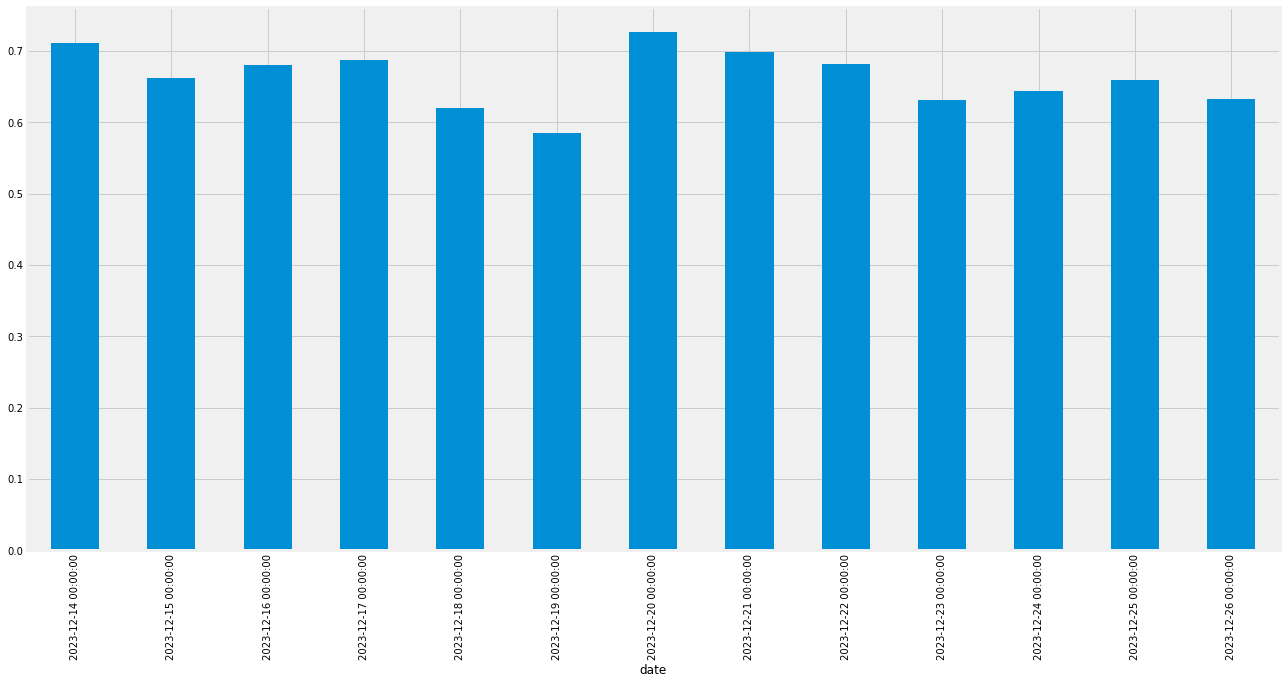

In [119]:
# Group by date columns from df and calculate the mean
mean_c = df.groupby(['date'])
mean_c = mean_c['compound'].mean()

# Plot a bar chart with pandas
mean_c.plot.bar(figsize = (20, 10))

We can see that overall, the average rating for Willy Wonka movie per day is positive. Now, let us see the movie reviews for 14th December 2023

In [125]:
# Filter the dataset for the date
filtered_df = df[df['date']=='2023-12-14']
filtered_df

,date,user_review,neg,neu,pos,compound
0,2023-12-14,Seeing a prequel that does have its reason for...,0.000,0.893,0.107,0.7717
1,2023-12-14,Great movie for families and young kids. Capit...,0.000,0.687,0.313,0.6249
2,2023-12-14,We really enjoyed it!!!!!,0.000,0.387,0.613,0.6967
3,2023-12-14,This movie was really good. Timothee Chalamet ...,0.012,0.739,0.249,0.9796
4,2023-12-14,Timothy Chalemet was painfully miscast as Wonk...,0.085,0.677,0.238,0.7264
5,2023-12-14,willy Wonka and the chocolate factory is my fa...,0.000,0.685,0.315,0.9518
6,2023-12-14,"Very enjoyable, well done modernized ""prequel""...",0.000,0.708,0.292,0.9696
7,2023-12-14,Fun holiday movie with some nostalgic moments!...,0.056,0.631,0.312,0.8372
8,2023-12-14,"LOVED IT!!! Sweet, funny, magical, and just ...",0.000,0.442,0.558,0.9565
9,2023-12-14,"To be honest, they need to stop remaking these...",0.142,0.645,0.213,0.2732


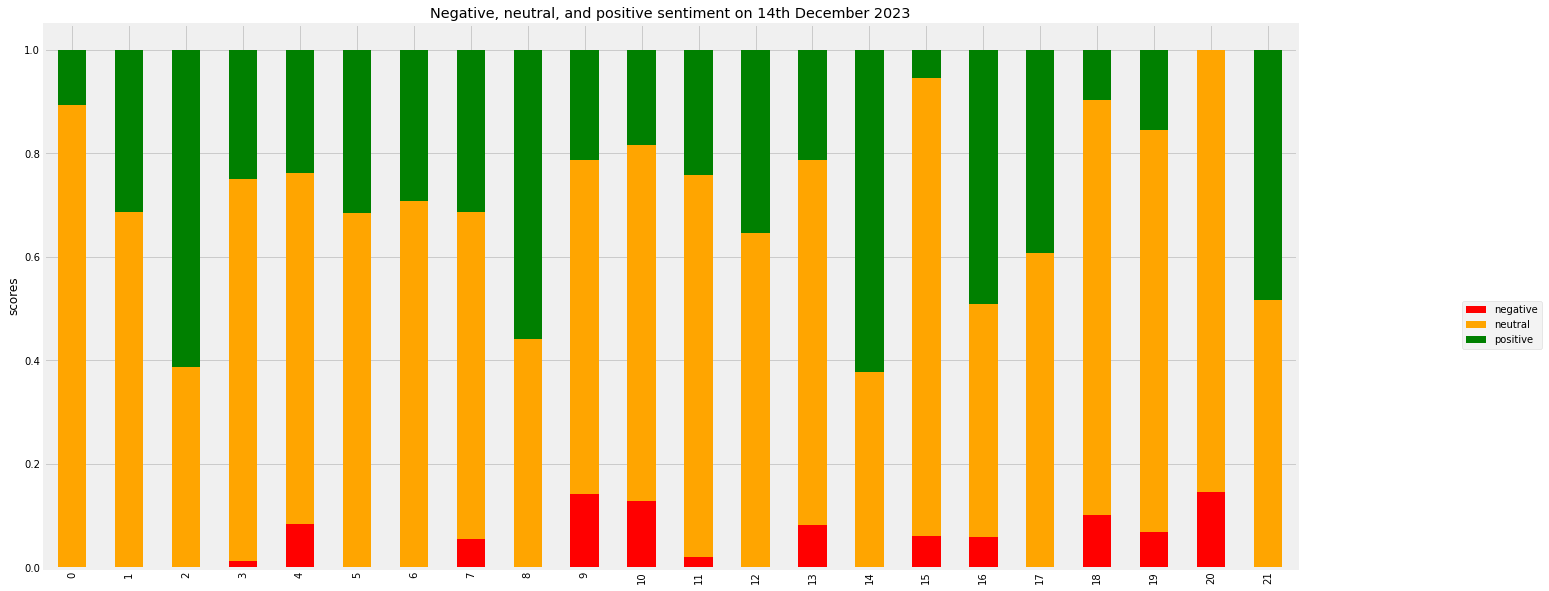

In [126]:
TITLE = "Negative, neutral, and positive sentiment on 14th December 2023"
COLORS = ["red","orange", "green"]

# Drop the columns that aren't useful for the plot
plot_day = filtered_df.drop(['date', 'user_review', 'compound'], axis=1)

# Change the column names to 'negative', 'positive', and 'neutral'
plot_day.columns = ['negative', 'neutral', 'positive']

# Plot a stacked bar chart
plot_day.plot.bar(stacked=True, figsize=(20, 10), title=TITLE, color=COLORS).legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel('scores');

# Last Words:
This project was inspired & guided by StackUp "AI/ML with Python: Web Scraping & Sentiment Analysis" Campaign, it was my attempt as beginner to apply what I've learned from the campaign to this notebook (since I am quite new to ML & NLP). In this project, I try to apply the technique that is used for web scraping using urlopen, BeautifulSoup, and WebDriver to get the movie reviews automatically from www.rottentomatoes.com & date of the reviews. After that, I used VADER to analyse the sentiments of each review that has been scraped & visualize it using Matplotlib bar chart. Lastly, if I'm correct then rotten tomatoes robots.txt should have allowed all user agent to scrap most of it website content (except those that falls under /search).